<a href="https://colab.research.google.com/github/leoexcelsus/siglla_phase2/blob/main/siglla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importar bibliotecas
import pandas as pd
import sys
import csv
import seaborn as sns

%matplotlib inline
from sklearn.preprocessing import  OneHotEncoder
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline



In [ ]:
# Salvando o modelo para posterior reuso
# from sklearn.externals import joblib
from joblib import dump, load
# import re

In [ ]:
csv.field_size_limit(sys.maxsize)
df = pd.read_csv('https://github.com/leoexcelsus/siglla_phase2/raw/main/ml_dataset_siglla%C2%A3.txt', sep="£",engine='python')
df['value'] = df['value'].map({'sim': 1, 'n': 0})
# df.describe()
df

,text,value
0,"LEI COMPLEMENTAR Nº 140, DE 8 DE DEZEMBRO DE 2...",1
1,"LEI Nº 6.938, DE 31 DE AGOSTO DE 1981 Regulame...",1
2,"DECRETO Nº 8.437, DE 22 DE ABRIL DE 2015 Regul...",1
3,"LEI Nº 13.874, DE 20 DE SETEMBRO DE 2019 Mensa...",1
4,"LEI No 9.985, DE 18 DE JULHO DE 2000. Mensagem...",1
...,...,...
254,Ir para o conteúdo Ir para o rodapé IR PARA O ...,0
255,DIÁRIO OFICIAL DA UNIÃO Publicado em: 22/02/20...,0
256,"PORTARIA N° 121, DE 1º DE MARÇO DE 2016 O SECR...",0
257,DIÁRIO OFICIAL DA UNIÃO Publicado em: 01/03/20...,0


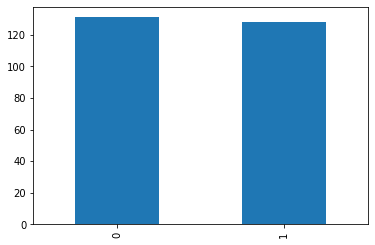

In [ ]:
df.value.value_counts().plot(kind='bar')

In [ ]:
# Separa os dados de treino e teste (proporção 80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.text, df.value, test_size=0.2, 
                                                    stratify=df.value,random_state=42)

In [ ]:
X_train[:10]

175    DIÁRIO OFICIAL DA UNIÃO Publicado em: 25/01/20...
150    PORTARIA Nº 224, DE 19 DE JUNHO DE 2015 O MINI...
172    Ir para o conteúdo Ir para o rodapé IR PARA O ...
147    RESOLUÇÃO No - 4.652, DE 1o - DE ABRIL DE 2015...
52     LEI No 9.985, DE 18 DE JULHO DE 2000. Regulame...
93     RESOLUÇÃO CONAMA nº 281, de 12 de julho de 200...
86     RESOLUÇÃO CONAMA Nº 23, DE 7.12.1994 - DOU 30....
252    O SUPERINTENDENTE DO PATRIMÔNIO DA UNIÃONO RIO...
256    PORTARIA N° 121, DE 1º DE MARÇO DE 2016 O SECR...
140    AÇÃO DIRETA DE INCONSTITUCIONALIDADE 3.580 (6)...
Name: text, dtype: object

In [ ]:
# Confere a proporção das classes nos dados de treino e de teste
print('TREINO : ',y_train.shape,'\n', y_train.value_counts(normalize=True),'\n')
print('TESTE  : ',y_test.shape,'\n', y_test.value_counts(normalize=True))

TREINO :  (207,) 
 0    0.507246
1    0.492754
Name: value, dtype: float64 

TESTE  :  (52,) 
 1    0.5
0    0.5
Name: value, dtype: float64


In [ ]:
# instancia o transform CountVectorizer
tfidf_vectorizer = TfidfVectorizer()
# tokeniza e cria o vocabulário
tfidf_vectorizer.fit(X_train)
# mostra o vocabulário criado
print('Vocabulário: ')
print(tfidf_vectorizer.vocabulary_)

# encode document
tfidf_vector = tfidf_vectorizer.transform(X_train)
# mostra as dimensões da matrix de frequência
print('\nDimensões da matrix: ')
print(tfidf_vector.shape)

Vocabulário: 
{'diário': 14015, 'oficial': 25762, 'da': 11416, 'união': 35244, 'publicado': 29264, 'em': 15108, '25': 1566, '01': 191, '2011': 1430, 'edição': 14747, '17': 1179, 'seção': 32601, 'página': 29333, 'órgão': 36598, 'presidência': 28444, 'república': 30870, 'casa': 7832, 'civil': 8474, 'portarias': 27963, 'de': 11744, '24': 1538, 'janeiro': 21428, 'ministro': 23883, 'estado': 16323, 'chefe': 8252, 'no': 24958, 'uso': 35309, 'suas': 33265, 'atribuições': 6092, 'etendo': 16620, 'vista': 35949, 'disposto': 13876, 'art': 5652, '1o': 1386, 'do': 14036, 'decreto': 12038, '734': 2543, '11': 642, 'dejunho': 12304, '2003': 1416, 'resolve': 30988, 'nº': 25262, '331': 1762, 'nomear': 25030, 'cláudio': 8600, 'frederico': 18279, 'matos': 23328, 'arruda': 5646, 'para': 26578, 'exercer': 16931, 'ocargo': 25602, 'assessoria': 5821, 'diplomática': 13683, 'vice': 35786, 'darepública': 11633, 'código': 11389, 'das': 11640, '101': 508, 'antonio': 4875, 'palocci': 26545, 'filho': 17724, 'portari

In [ ]:
# Define o pipeline incluindo o extrator de 'features do texto e um classificador

pipeline = Pipeline([
    ('vect', CountVectorizer(max_df=1.0, max_features=50000,ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf=True,norm='l2')),
    ('clf', SGDClassifier(loss='log',alpha=1e-06, penalty='elasticnet', max_iter=60)), # default hinge. to get proba=log or modified_huber
])

In [ ]:
%%time
# Treine o modelo(fit)
classificador = pipeline.fit(X_train, y_train)

CPU times: user 2.67 s, sys: 119 ms, total: 2.79 s
Wall time: 2.76 s


In [ ]:
# Faça a predição nos dados de teste
predicted = classificador.predict(X_test)

In [ ]:
# Mostra a acurácia do modelo nos dados de teste 
classificador.score(X_test,y_test)

0.9615384615384616

In [ ]:
# Mostra o f1 score do modelo nos dados de teste (usado quando as classes estão desbalanceadas)
from sklearn.metrics import f1_score
f1_score(y_test, predicted, average='weighted')

0.9614814814814815

In [ ]:
# avalie o modelo usando 'claasification_report' do sklearn
from sklearn import metrics
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        26
           1       0.93      1.00      0.96        26

    accuracy                           0.96        52
   macro avg       0.96      0.96      0.96        52
weighted avg       0.96      0.96      0.96        52



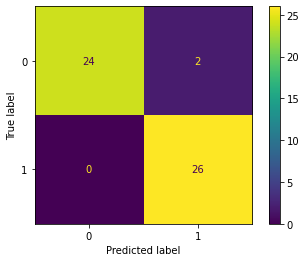

In [ ]:
# mostrar a matrix de confusão do modelo sobre todo o dataset
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(classificador, X_test, y_test, values_format='d')

In [ ]:
df['predicao'] = (lambda x: classificador.predict(x))
df

,text,value,predicao
0,"LEI COMPLEMENTAR Nº 140, DE 8 DE DEZEMBRO DE 2...",1,<function <lambda> at 0x7fc93f4cf9d8>
1,"LEI Nº 6.938, DE 31 DE AGOSTO DE 1981 Regulame...",1,<function <lambda> at 0x7fc93f4cf9d8>
2,"DECRETO Nº 8.437, DE 22 DE ABRIL DE 2015 Regul...",1,<function <lambda> at 0x7fc93f4cf9d8>
3,"LEI Nº 13.874, DE 20 DE SETEMBRO DE 2019 Mensa...",1,<function <lambda> at 0x7fc93f4cf9d8>
4,"LEI No 9.985, DE 18 DE JULHO DE 2000. Mensagem...",1,<function <lambda> at 0x7fc93f4cf9d8>
...,...,...,...
254,Ir para o conteúdo Ir para o rodapé IR PARA O ...,0,<function <lambda> at 0x7fc93f4cf9d8>
255,DIÁRIO OFICIAL DA UNIÃO Publicado em: 22/02/20...,0,<function <lambda> at 0x7fc93f4cf9d8>
256,"PORTARIA N° 121, DE 1º DE MARÇO DE 2016 O SECR...",0,<function <lambda> at 0x7fc93f4cf9d8>
257,DIÁRIO OFICIAL DA UNIÃO Publicado em: 01/03/20...,0,<function <lambda> at 0x7fc93f4cf9d8>


In [ ]:
# fazer predição do tipo de norma para uma nova norma: [Resolução CONAMA 428/2010]
predicted = classificador.predict(['O CONSELHO NACIONAL DO MEIO AMBIENTE-CONAMA, no uso das atribuições e competências que lhe são conferidas pelo art. 8º da Lei nº 6.938, de 31 de agosto de 1981, regulamentado pelo Decreto nº 99.274, de 06 de julho de 1990 e tendo em vista o disposto em seu Regimento Interno, Anexo à Portaria MMA nº 168, de 13 de junho de 2005, e: Considerando a necessidade de regulamentar os procedimentos de licenciamento ambiental de empreendimentos de significativo impacto ambiental que afetem as Unidades de Conservação específicas ou suas zonas de amortecimento, resolve: Art. 1º O licenciamento de empreendimentos de significativo impacto ambiental que possam afetar Unidade de Conservação (UC) específica ou sua Zona de Amortecimento (ZA), assim considerados pelo órgão ambiental licenciador, com fundamento em Estudo de Impacto Ambiental e respectivo Relatório de Impacto Ambiental (EIA/RIMA), só poderá ser concedido após autorização do órgão responsável pela administração da UC ou, no caso das Reservas'])

In [ ]:
print('nova predição:\nclasse = ', predicted)
print('classe = ', df.value[predicted])

nova predição:
classe =  [1]
classe =  1    1
Name: value, dtype: int64
